In [6]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import ompy
import copy
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: not enough values to unpack (expected 2, got 0)

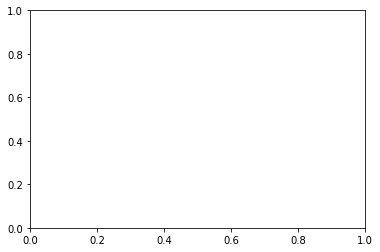

In [8]:
# Import raw matrix into instance of om.Matrix() and plot it
fname_raw = "../tests/mock/Dy164_raw.m"
raw = ompy.Matrix(fname_raw)
raw.plot(title="raw")